# Imaging Time-Series to Improve Classification

The Deep Learning boom is largely fueled by its success in computer vision and speech recognition. However, when it comes to time series, building predictive models can be gruesome (Recurrent Neural Networks are difficult to train, research is less applicable, and no pre-trained models exist, 1D-CNN can be inconvenient).

https://arxiv.org/pdf/1506.00327.pdf

## Mathematics pre-requistes
The inner product between two vectors, is a measure of how close the two vectors are.
In the simplest case (2D space), the inner production between two vector $\vec{u}$ and $\vec{v}$ is defined as: <br>
$\left<\vec{u}, \vec{v}\right> = u_1 . v_1 + u_2 . v_2$<br>
In other way, <br>
$\left<\vec{u}, \vec{v}\right> = ||\vec{v}|| . ||\vec{v}|| .\text{cos}(\theta)$ <br>
If the vectors of norm 1, we have: <br>
$\left<\vec{u}, \vec{v}\right> = \cos(\theta)$ <br>
Therefore, when dealing with unit vectors, their inner product is solely characterized by the angle θ (expressed in radian) between u and v. Furthermore, the resulting value lies within [-1, 1]. <br>

## Gram Matrix
The Gram Matrix is a useful tool in Linear Algebra and Geometry. Among others, it is frequently used to compute the linear dependence of a set of vectors.<br>
Definition: the Gram Matrix of a set of n vectors is a matrix defined by the dot-product (see similarity) of every couple of vectors. Mathematically, this translates to:<br>
$G = \begin{bmatrix}
\left<\vec{v_1}, \vec{v_1}\right> & \left<\vec{v_1}, \vec{v_2}\right> & \cdots & \left<\vec{v_1}, \vec{v_n}\right> \\
\left<\vec{v_2}, \vec{v_1}\right>  & \left<\vec{v_2}, \vec{v_2}\right>  & \cdots & \left<\vec{v_2}, \vec{v_n}\right> \\
\vdots & \vdots & \ddots & \vdots \\
\left<\vec{v_n}, \vec{v_1}\right>  & \left<\vec{v_n}, \vec{v_2}\right>  & \cdots & \left<\vec{v_n}, \vec{v_n}\right>  
\end{bmatrix}  $<br>

Assuming all 2D vectors of norm 1: <br>
$G = \begin{bmatrix}
\cos(\phi_{1,1}) & \cos(\phi_{1,2}) & \cdots & \cos(\phi_{1,n}) \\
\cos(\phi_{2,1})  & \cos(\phi_{2,2})  & \cdots & \cos(\phi_{2,n}) \\
\vdots & \vdots & \ddots & \vdots \\
\cos(\phi_{n,1})  & \cos(\phi_{n,2})  & \cdots & \cos(\phi_{n,n})  
\end{bmatrix}  $<br>

The Gram Matrix preserves the temporal dependency. Since time increases as the position moves from top-left to bottom-right, the time dimension is encoded into the geometry of the matrix. <br>
Any inner product will remove information about the two vectors of observation, so instead we define new operation for the inner product:<br>
$x\bigoplus y = \cos(\phi_1+\phi_2)$<br>
And so the gram matrix
$G = \begin{bmatrix}
\cos(\phi_1+\phi_1) & \cos(\phi_1+\phi_2) & \cdots & \cos(\phi_1+\phi_n) \\
\cos(\phi_2+\phi_1)  & \cos(\phi_2+\phi_2)  & \cdots & \cos(\phi_2+\phi_n) \\
\vdots & \vdots & \ddots & \vdots \\
\cos(\phi_n+\phi_1)  & \cos(\phi_n+\phi_2)  & \cdots & \cos(\phi_n+\phi_n)  
\end{bmatrix}  $<br>


## Implementation
### Scale timeseries onto [-1,1] using min max scaler
Scale the timeseries between [-1,1] this is useful if we convert the data into polar coordinate, since $\cos(\phi)$ lies between [-1,1] <br>
![polar](image/polar.png")
Assuming our time series is composed of $N$ timestamps $t$ with corresponding values $x$, then:
* The angles are computed using $\cos^{-1}(x)$, they lie between [0,$\Pi$].
* The radius variable is computed as:$\frac{t}{N}$



In [1]:
# Example
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
from fastai.vision import *
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GASF, GADF
import pandas as pd
# Math
import math
import numpy as np
from datetime import datetime, timedelta
import scipy

In [3]:
#parameters
bs = 64
n_classes = 3
n_samples = 28


In [4]:


# Tools
def tabulate(x, y, f):
    """Return a table of f(x, y). Useful for the Gram-like operations."""
    return np.vectorize(f)(*np.meshgrid(x, y, sparse=True))
def cos_sum(a, b):
    """To work with tabulate."""
    return(math.cos(a+b))

class GAF:

    def __init__(self):
        pass
    def __call__(self, serie):
        """Compute the Gramian Angular Field of an image"""
        # Min-Max scaling
        min_ = np.amin(serie)
        max_ = np.amax(serie)
        scaled_serie = (2*serie - max_ - min_)/(max_ - min_)

        # Floating point inaccuracy!
        scaled_serie = np.where(scaled_serie >= 1., 1., scaled_serie)
        scaled_serie = np.where(scaled_serie <= -1., -1., scaled_serie)

        # Polar encoding
        phi = np.arccos(scaled_serie)
        # Note! The computation of r is not necessary
        r = np.linspace(0, 1, len(scaled_serie))

        # GAF Computation (every term of the matrix)
        gaf = tabulate(phi, phi, cos_sum)

        return(gaf, phi, r, scaled_serie)

In [5]:

# Toy dataset
X = np.linspace(0,1,num=n_samples) **2
gaf = GAF()
g, _,_,_ = gaf(X)
print(g.shape)

(28, 28)


Text(0.5, 1.0, 'GAF')

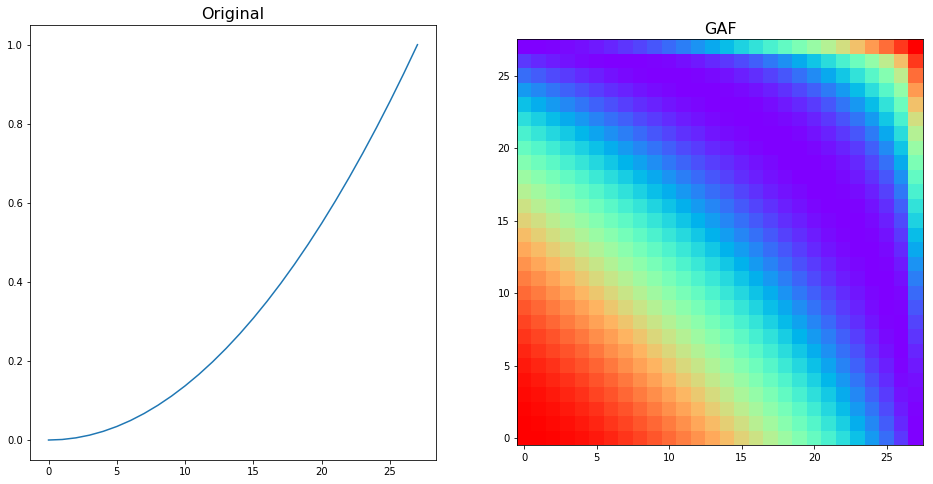

In [6]:
# Show the results for the first time series
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.plot(X)
plt.title("Original", fontsize=16)
plt.subplot(122)
plt.imshow(g, cmap='rainbow', origin='lower')
plt.title("GAF", fontsize=16)

In [7]:
xjo = pd.read_csv('./data/axjo.csv', parse_dates=['Date'], index_col=[0])
print(xjo.head().T)

Date         2014-01-08    2014-01-09    2014-01-12    2014-01-13  \
Open       5.316000e+03  5.324400e+03  5.312400e+03  5.292100e+03   
High       5.324400e+03  5.324400e+03  5.318000e+03  5.292100e+03   
Low        5.295400e+03  5.306300e+03  5.288100e+03  5.207500e+03   
Close      5.324400e+03  5.312400e+03  5.292100e+03  5.212000e+03   
Adj Close  5.324400e+03  5.312400e+03  5.292100e+03  5.212000e+03   
Volume     4.591164e+08  4.708812e+08  3.945188e+08  6.046564e+08   

Date         2014-01-14  
Open       5.212000e+03  
High       5.256100e+03  
Low        5.212000e+03  
Close      5.245400e+03  
Adj Close  5.245400e+03  
Volume     5.360873e+08  


In [8]:
xjo['Value'] = (xjo['High']+xjo['Low'])/2.0
y = xjo['Value']
ahead = y.shift(-1)
new_y = 100.0*(ahead/y-1)
y = pd.qcut(new_y, 3,labels=False).dropna().astype('int')
print(y.head(10), xjo['Value'].head(10))

Date
2014-01-08    1
2014-01-09    0
2014-01-12    0
2014-01-13    0
2014-01-14    2
2014-01-15    2
2014-01-16    0
2014-01-19    2
2014-01-20    1
2014-01-21    0
Name: Value, dtype: int32 Date
2014-01-08    5309.899902
2014-01-09    5315.349853
2014-01-12    5303.050049
2014-01-13    5249.800049
2014-01-14    5234.050049
2014-01-15    5277.250000
2014-01-16    5301.599853
2014-01-19    5283.149902
2014-01-20    5303.800049
2014-01-21    5308.449951
Name: Value, dtype: float64


# Create dataset

In [9]:
path = Path('./data')
print(path.ls())

[WindowsPath('data/AXJO.csv'), WindowsPath('data/Bearish'), WindowsPath('data/Bullish'), WindowsPath('data/models'), WindowsPath('data/Neutral')]


In [10]:
import cv2
for i in range(n_samples, len(y)):
    index = y.index[i]
    start = y.index[i-n_samples]
    series = xjo[start:index].Value[:n_samples]
    img, _,_,_  = gaf(series.values)
    img = (1+img)*255/2.0
    img = img.astype('int').reshape(n_samples, n_samples, 1)
    
    
  
    if y[index] == 0:
        file = f'./data/Bearish/{index.date()}.png'
        #print(f'Write bearish to : {file}')
        cv2.imwrite(file, img)
    elif y[index] == 1:
        file = f'./data/Neutral/{index.date()}.png'
        #print(f'Write neutral to : {file}')
        cv2.imwrite(file, img)
    else:
        file = f'./data/Bullish/{index.date()}.png'
        #print(f'Write bullish to : {file}')
        cv2.imwrite(file, img)
        
        
        

c:\workspace\continuum\anaconda3\envs\py36\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\workspace\continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater_equal
c:\workspace\continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less_equal


In [10]:
il = ImageItemList.from_folder(path, convert_mode='L')

In [11]:
il.items[0]

WindowsPath('data/Bearish/2014-02-25.png')

In [12]:
defaults.cmap='binary'

In [13]:
il

ImageItemList (1233 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: data

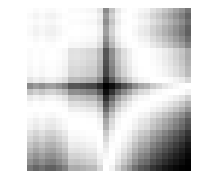

In [14]:
il[0].show()

In [15]:
sd = il.random_split_by_pct(valid_pct = 0.2)

In [16]:
sd

ItemLists;

Train: ImageItemList (987 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: data;

Valid: ImageItemList (246 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: data;

Test: None

In [17]:
ll = sd.label_from_folder()

In [18]:
ll

LabelLists;

Train: LabelList
y: CategoryList (987 items)
[Category Bearish, Category Bearish, Category Bearish, Category Bearish, Category Bearish]...
Path: data
x: ImageItemList (987 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: data;

Valid: LabelList
y: CategoryList (246 items)
[Category Neutral, Category Bullish, Category Neutral, Category Bearish, Category Bullish]...
Path: data
x: ImageItemList (246 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: data;

Test: None

In [19]:
x,y = ll.train[0]

Bearish torch.Size([1, 28, 28])


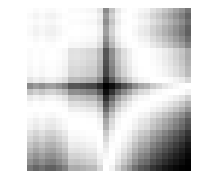

In [20]:
x.show()
print(y,x.shape)

In [21]:
bs = 128

In [22]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [23]:
x,y = data.train_ds[0]

Bearish


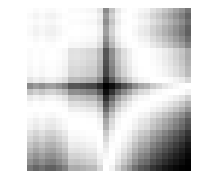

In [24]:
x.show()
print(y)

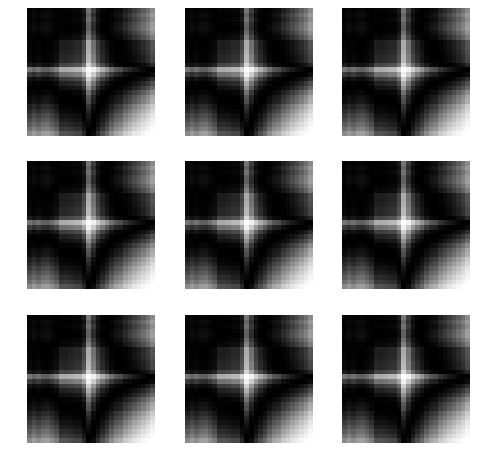

In [25]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [26]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

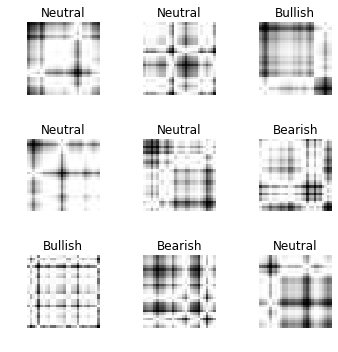

In [27]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with batchnorm

In [28]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [54]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, n_classes), # 1
    nn.BatchNorm2d(n_classes),
    Flatten()     # remove (1,1) grid
)

In [55]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [56]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [128, 8, 14, 14]     80         True      
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
Conv2d               [128, 16, 7, 7]      1168       True      
______________________________________________________________________
BatchNorm2d          [128, 16, 7, 7]      32         True      
______________________________________________________________________
ReLU                 [128, 16, 7, 7]      0          False     
______________________________________________________________________
Conv2d               [128, 32, 4, 4]      4640       True      
______________________________________________________________

In [57]:
xb = xb.cuda()

In [58]:
model(xb).shape

torch.Size([128, 3])

In [ ]:
learn.lr_find(end_lr=2)

In [ ]:
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(3, max_lr=0.03)

epoch,train_loss,valid_loss,accuracy
1,1.168968,1.097522,0.345528
2,1.129363,1.093452,0.402439
3,1.101324,1.090720,0.353659


#### Fit one cycle
https://sgugger.github.io/the-1cycle-policy.html


### Refactor

In [37]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [38]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, n_classes), # 1
    Flatten()      # remove (1,1) grid
)

In [39]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [40]:
learn.fit_one_cycle(10, max_lr=0.03)

epoch,train_loss,valid_loss,accuracy
1,1.253398,1.104679,0.337398
2,1.165214,1.112205,0.317073
3,1.114024,1.127045,0.382114
4,1.078905,1.132521,0.341463
5,1.042105,1.217651,0.325203
6,1.001665,1.211643,0.369919
7,0.952044,1.219726,0.369919
8,0.901123,1.283984,0.333333
9,0.850093,1.270016,0.333333
10,0.808134,1.259383,0.329268


### Resnet-ish

In [41]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [42]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **kwargs)
    Resnet block of `nf` features.



In [43]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, n_classes),
    Flatten()
)

In [44]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [45]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, n_classes),
    Flatten()
)

In [46]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


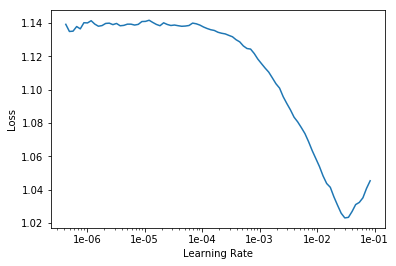

In [48]:
learn.lr_find(end_lr=0.2)
learn.recorder.plot()

In [49]:
learn.fit_one_cycle(12, max_lr=0.005)

epoch,train_loss,valid_loss,accuracy
1,1.138217,1.096357,0.357724
2,1.092659,1.096493,0.349593
3,1.042000,1.096244,0.390244
4,0.996576,1.103899,0.369919
5,0.951297,1.133930,0.325203
6,0.911662,1.154461,0.321138
7,0.870015,1.159694,0.341463
8,0.829943,1.171255,0.321138
9,0.792723,1.184213,0.300813
10,0.759569,1.187976,0.292683


In [50]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [128, 8, 14, 14]     72         True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
Conv2d               [128, 8, 14, 14]     576        True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
Conv2d               [128, 8, 14, 14]     576        True      
______________________________________________________________